In [ ]:
import pandas as pd
import numpy as np
import requests
import pickle
from io import BytesIO
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings

In [ ]:
with open('/content/df.pkl', 'rb') as f:
    df = pickle.load(f)

df.head()

,item_nbr,year,month,onpromotion_anytime_in_month,unit_sales,year_month,family,class,perishable
0,103520,2013,1,True,201.0,2013-1,GROCERY I,1028,0
1,103520,2013,2,True,179.0,2013-2,GROCERY I,1028,0
2,103520,2013,3,True,296.0,2013-3,GROCERY I,1028,0
3,103520,2013,4,True,212.0,2013-4,GROCERY I,1028,0
4,103520,2013,5,True,172.0,2013-5,GROCERY I,1028,0


In [ ]:
# logic that removes a item_nbr if it doesn't have all the months the other rows have

all_y_months = df['year_month'].unique()

for item_nbr in df['item_nbr'].unique():
    if len(df[df['item_nbr'] == item_nbr]['year_month'].unique()) != len(all_y_months):
        df = df[df['item_nbr'] != item_nbr]

len(df['item_nbr'].unique())

1025

In [ ]:
df = df[df['unit_sales'] > 0]

In [ ]:
df.rename(columns={'year_month': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)

In [ ]:
def plot_series(original, trend, seasonal, resid):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    original.plot(ax=ax[0])
    ax[0].set_title('Original')
    trend.plot(ax=ax[1])
    ax[1].set_title('Trend')
    seasonal.plot(ax=ax[2])
    ax[2].set_title('Seasonal')
    resid.plot(ax=ax[3])
    ax[3].set_title('Residual')
    plt.tight_layout()

    plt.show()

In [ ]:
def decompose_series(series, period=12):
    decomposition = seasonal_decompose(series, period=period)
    plot_series(series, decomposition.trend, decomposition.seasonal, decomposition.resid)
    return decomposition

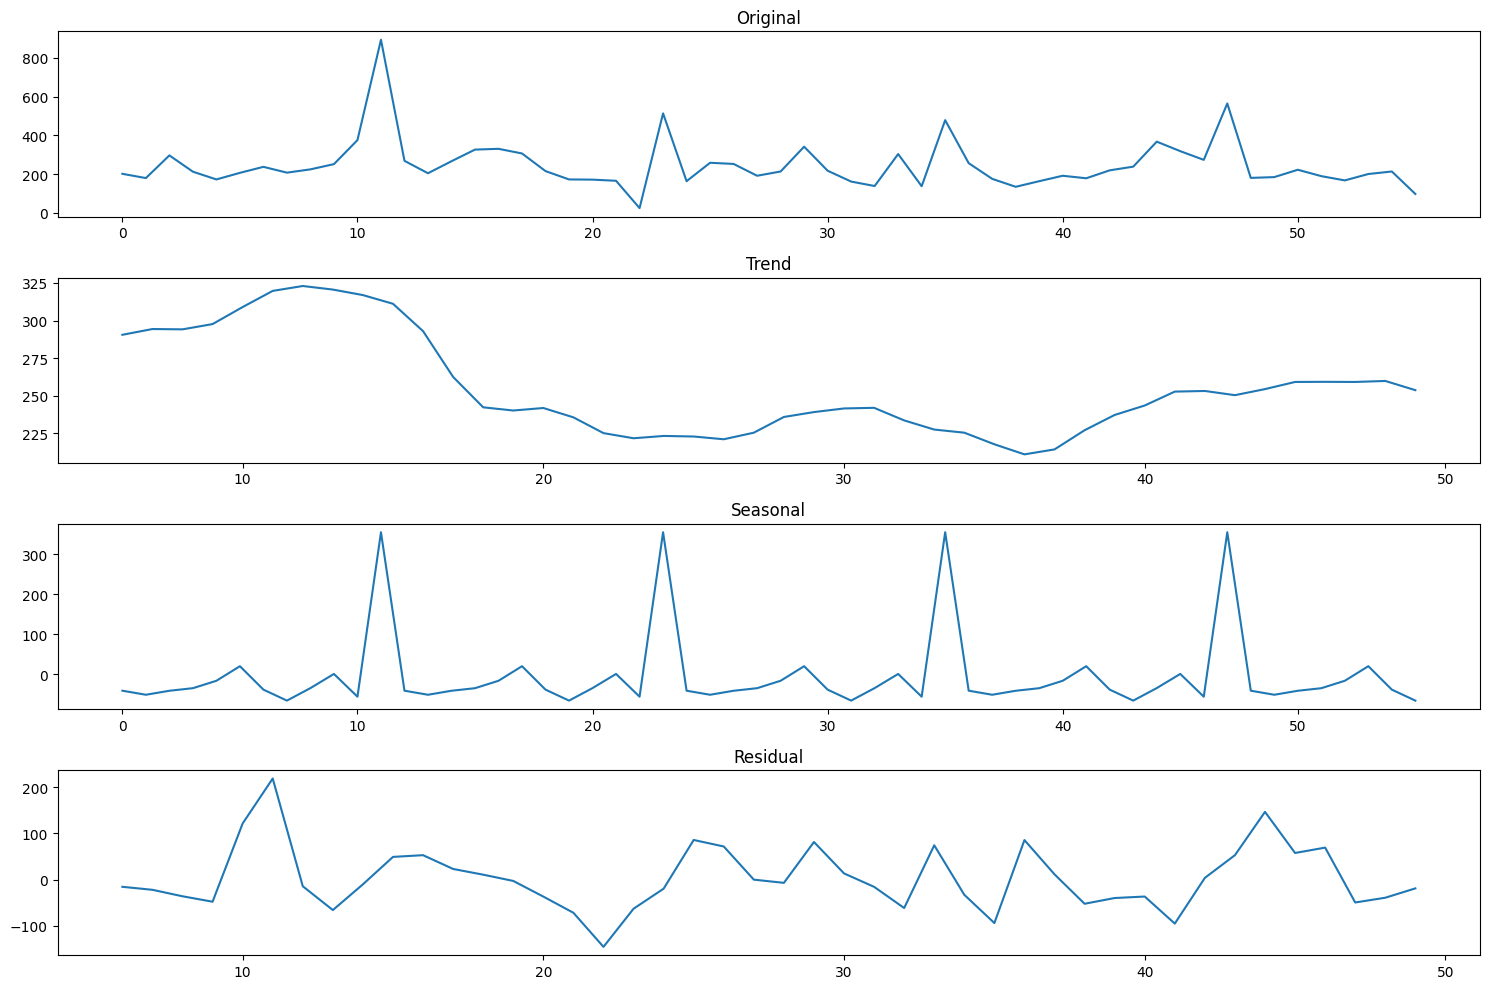

In [ ]:
# decompor a série temporal em 3 componentes: tendência, sazonalidade e resíduosfrom statsmodels.tsa.seasonal import seasonal_decompose

item_nbr = 103520

df_item = df[df['item_nbr'] == item_nbr]

df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()

decompose_series(df_item['unit_sales'], period=12)

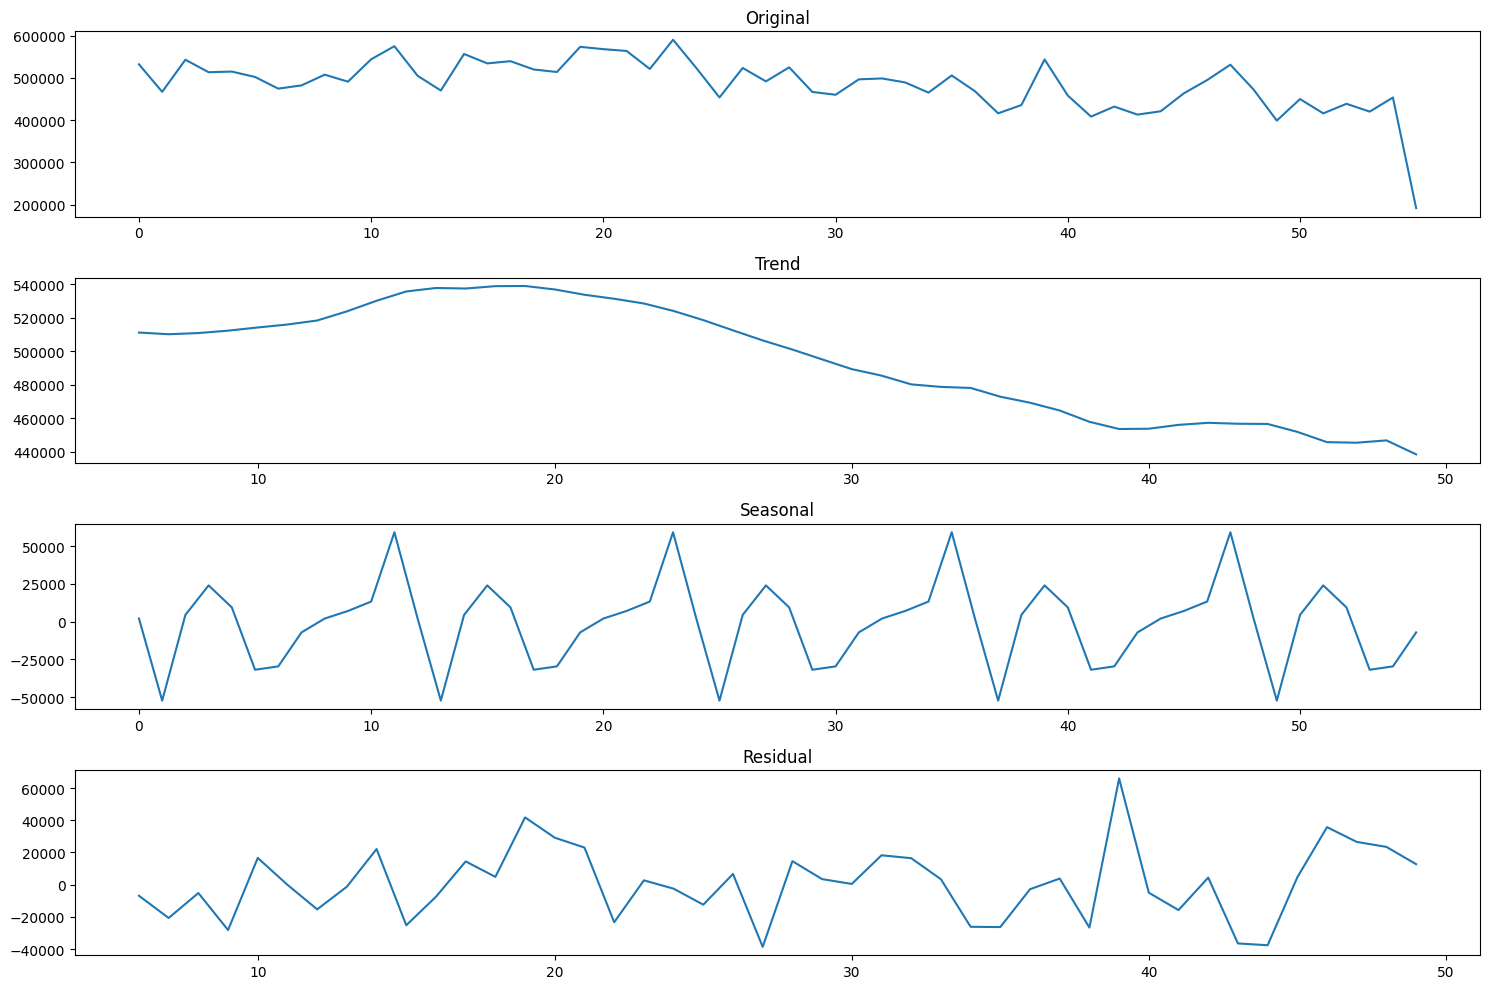

In [ ]:
df_agg = df.groupby('date')['unit_sales'].sum().reset_index()

decompose_series(df_agg['unit_sales'], period=12)

# Testando a autocorrelação dos dados

In [ ]:
# reiniciando o indice

new_df_agg = df_agg.reset_index(drop=True)
new_df_agg.drop(columns='date', inplace=True)

new_df_item = df_item.reset_index(drop=True)
new_df_item.drop(columns='date', inplace=True)

Valores da ACF para diferentes lags:
[1.         0.37297716 0.31590044 0.30894829 0.33124689 0.25518366
 0.2862718  0.24527556 0.18802033 0.17631785 0.12508873 0.23974962
 0.30176864]


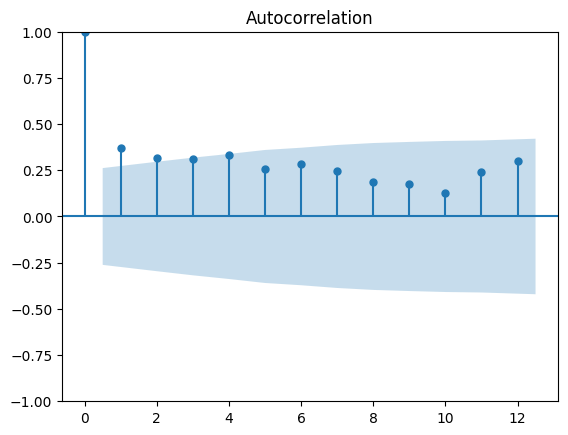

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calcular a função de autocorrelação
acf_values = sm.tsa.acf(new_df_agg, nlags=12)
print("Valores da ACF para diferentes lags:")
print(acf_values)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(new_df_agg, lags=12)
plt.show()

Valores da ACF para diferentes lags:
[ 1.          0.08694977  0.03032105  0.0023671  -0.04200864 -0.0484738
  0.02339997 -0.11712815 -0.17364013 -0.05363624 -0.09285426 -0.23404751
  0.34200938]


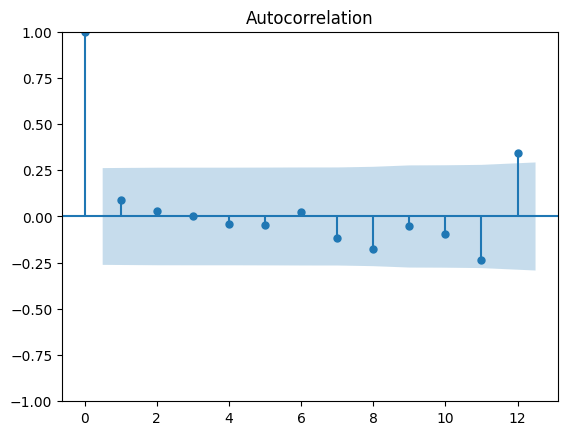

In [ ]:
# Calcular a função de autocorrelação
acf_values = sm.tsa.acf(new_df_item, nlags=12)
print("Valores da ACF para diferentes lags:")
print(acf_values)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(new_df_item, lags=12)
plt.show()

# Avaliando residuais

Pressupostos para previsão

*   Não devem estar autocorrelacionados
*   Média deve ser zero (aproximadamente)
*   Variância constante
*   Distribuição normal

In [ ]:
decomposition = seasonal_decompose(df_item['unit_sales'], period=12)
residuos_item = decomposition.resid
residuos_item.isna().sum()

12

Devido aos valores nan, não consegui verificar a autocorrelação dos residuos. Será necessário tratar os dados de alguma forma (dropar ou trocar por outro valor).

In [ ]:
residuos_item.mean()

3.1498842592592666

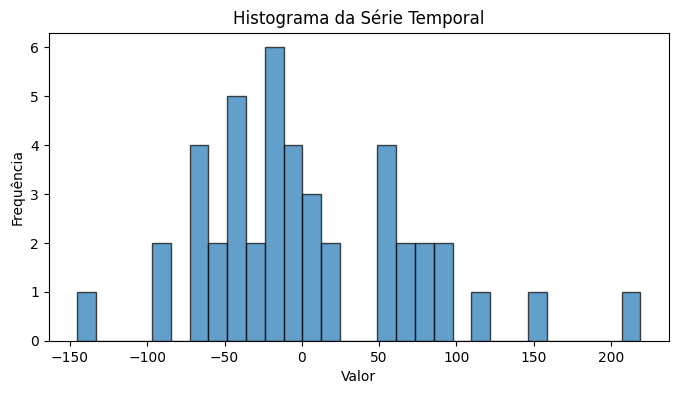

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(residuos_item, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma da Série Temporal')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

# Utilizando a biblioteca Lazypredict

In [ ]:
!pip install lazypredict

In [ ]:
# utilizando lazy prediction para escolher um modelo

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

X = df_agg.index
y = df_agg['unit_sales']

X = pd.DataFrame(X, columns=['index']) # Convert X to a DataFrame

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

 81%|████████  | 34/42 [00:01<00:00, 30.19it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(44, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:01<00:00, 28.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1
[LightGBM] [Info] Start training from score 484736.805043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.47,0.52,27748.31,0.07
HistGradientBoostingRegressor,0.46,0.51,28088.79,0.07
ElasticNet,0.40,0.45,29721.72,0.01
TweedieRegressor,0.38,0.44,29989.19,0.01
GammaRegressor,0.38,0.44,30081.66,0.02
AdaBoostRegressor,0.36,0.41,30693.35,0.05
HuberRegressor,0.34,0.40,30949.25,0.03
RANSACRegressor,0.33,0.39,31210.30,0.03
Ridge,0.20,0.27,34208.82,0.01


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings

# Suprimir todos os warnings
warnings.filterwarnings('ignore')

# Inicializar o LGBMRegressor
model = lgb.LGBMRegressor(
    n_estimators=100,       # Número de árvores
    learning_rate=0.1,      # Taxa de aprendizado
    max_depth=-1,           # Profundidade máxima das árvores (-1 significa sem limite)
    num_leaves=31,          # Número máximo de folhas em cada árvore
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1
[LightGBM] [Info] Start training from score 484736.805043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
# utilizando lazy prediction para escolher um modelo

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

X = df_item.index
y = df_item['unit_sales']

X = pd.DataFrame(X, columns=['index'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 42/42 [00:01<00:00, 35.01it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1
[LightGBM] [Info] Start training from score 248.113636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DummyRegressor,-0.13,-0.03,52.10,0.01
LarsCV,-0.13,-0.03,52.10,0.01
LassoLarsIC,-0.13,-0.03,52.10,0.01
LassoLarsCV,-0.13,-0.03,52.10,0.01
NuSVR,-0.22,-0.11,54.10,0.01
BayesianRidge,-0.42,-0.29,58.45,0.01
ElasticNetCV,-0.43,-0.30,58.55,0.07
TweedieRegressor,-0.54,-0.40,60.77,0.01
GammaRegressor,-0.54,-0.40,60.87,0.01
